In [1]:
# Running on GPU?
import setGPU

import getpass
import h5py
import pickle
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm

from tqdm import tnrange, tqdm_notebook

setGPU: Setting GPU to: 1


In [2]:
import os
import getpass
# Get permission to access EOS (Insert your NICE password)
os.system("echo %s | kinit" % getpass.getpass())

········


0

In [3]:
import json
import numpy as np
import pandas as pd
from pprint import pprint

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Lambda, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.activations import sigmoid, linear, relu
from keras.models import Model, load_model
from keras.regularizers import l1, l2, l1_l2

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr

Using TensorFlow backend.


In [4]:
plt.rcParams.update({'font.size': 22})

In [5]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

# Select PD
nPD = 11

In [6]:
legend = [{"name": 'pf_jets', "start": 0, "end": 776},
          {"name": 'cal_jet_mets', "start": 777, "end": 944},
          {"name": 'pho', "start": 945, "end": 1280},
          {"name": 'muons', "start": 1281, "end": 1784},
          {"name": 'pf_jets2', "start": 1785, "end": 1889},
          {"name": 'pf_mets', "start": 1890, "end": 1917},
          {"name": 'nvtx', "start": 1918, "end": 1924},
          {"name": 'cal_jet_mets2', "start": 1925},
          {"name": 'sc', "start": 2037, "end": 2127},
          {"name": 'cc', "start": 2128, "end": 2169},
          {"name": 'pho2', "start": 2170, "end": 2365},
          {"name": 'muons2', "start": 2366, "end": 2491},
          {"name": 'ebs', "start": 2492, "end": 2701},
          {"name": 'hbhef', "start": 2702, "end": 2764},
          {"name": 'presh', "start": 2765, "end": 2806},
          {"name": 'inst_lumi', "start": 2807, "end": 2808}]

In [7]:
# Feature description
feature_names = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEnhfEM', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi', 'inst_luminosity']

In [8]:
data_directory = "/eos/cms/store/user/fsiroky/consistentlumih5/"
label_file = "/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/JetHT.json"
pileup_file = "/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions16/13TeV/PileUp/pileup_latest.txt"
# model_directory = "/eos/user/t/tkrzyzek/autoencoder/plots_train_bottleneck/"
model_directory = "/eos/user/t/tkrzyzek/autoencoder/plots_train_w_pileup/"
# model_directory = "/eos/user/t/tkrzyzek/autoencoder/plots_train_w_pileup_no_bottleneck/"
# model_directory = "/eos/user/t/tkrzyzek/autoencoder/plots_train_no_pileup_no_bottleneck/"
model_name = "model"

In [9]:
def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

files = get_file_list(data_directory, PDs, nPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, nPD, "signal", ".h5")

In [10]:
# Load good and bad jets
def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

data = pd.DataFrame(get_data(files))

Reading: JetHT_C_background
Reading: JetHT_D_background
Reading: JetHT_E_background
Reading: JetHT_F_background
Reading: JetHT_G_background
Reading: JetHT_H_background
Reading: JetHT_C_signal
Reading: JetHT_D_signal
Reading: JetHT_E_signal
Reading: JetHT_F_signal
Reading: JetHT_G_signal
Reading: JetHT_H_signal


In [11]:
data["run"] = data[2807].astype(int)
data["lumi"] = data[2808].astype(int)
data["inst_lumi"] = data[2809].astype(float)

# Drop unnecessary meta data
data.drop([2808, 2809, 2810, 2811, 2812], axis=1, inplace=True)

# Append inst. luminosity at the end as well
data[2807] = data["inst_lumi"]

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

# Reset index
data = data.reset_index(drop=True)  

runIDs  = data["run"].astype(int)
lumiIDs = data["lumi"].astype(int)
luminosity = data["inst_lumi"].astype(float)

In [12]:
# Apply labels
output_json = json.load(open(label_file))

def json_checker(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(output_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

In [13]:
with open(pileup_file) as f:
    pileup = json.load(f)

def pileup_from_json(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid == i[0]:
                return i[3]
    except KeyError:
        print('key error')
    return 1

def add_pileup(sample):
    return pileup_from_json(pileup, sample["run"], sample["lumi"])

data["pileup"] = data.apply(add_pileup, axis=1)

In [14]:
data[2808] = data["pileup"]

In [15]:
# Split the data
TRAIN_FROM = round(0.8*len(data))
TRAIN_TO = round(0.9*len(data))
TEST_FROM = round(0.9*len(data))

train = data.iloc[TRAIN_FROM:TRAIN_TO]
X_train = pd.concat([train.iloc[:, :2808], train[2808]], axis=1)
y_train = train["label"]

# Adding bad data to test set
test = pd.concat([data.iloc[TEST_FROM:], data[:TEST_FROM][data['label'] == 1]]) 
X_test = pd.concat([test.iloc[:, :2808], test[2808]], axis=1)
y_test = test["label"]

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Train only on good
X_train = X_train[y_train == 0]
X_train_norm = X_train_norm[y_train == 0]

/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [16]:
INPUT_DIM = 2809

In [17]:
X_test_norm.shape

(18698, 2809)

In [18]:
input_layer = Input(shape=(INPUT_DIM, ))

x = Dense(2048, kernel_regularizer=l1_l2(10e-5))(input_layer)
x = PReLU()(x)

x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(64, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(2048, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(INPUT_DIM)(x)

autoencoder = Model(inputs=input_layer, outputs=x)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2809)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              5754880   
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 2048)              2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 1024)              1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 512)               512       
__________

In [19]:
adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

In [20]:
autoencoder.fit(X_train_norm,
                X_train_norm,
                epochs=2048,
                batch_size=256,
                validation_split=0.25,
                verbose=2,
                callbacks=[early_stopper, checkpoint_callback])

Train on 11817 samples, validate on 3940 samples
Epoch 1/2048
7s - loss: 89.1891 - val_loss: 76.6382
Epoch 2/2048
3s - loss: 66.8962 - val_loss: 57.4195
Epoch 3/2048
5s - loss: 50.1406 - val_loss: 43.0679
Epoch 4/2048
5s - loss: 37.6129 - val_loss: 32.3247
Epoch 5/2048
4s - loss: 28.2433 - val_loss: 24.3003
Epoch 6/2048
7s - loss: 21.2582 - val_loss: 18.3301
Epoch 7/2048
6s - loss: 16.0693 - val_loss: 13.9039
Epoch 8/2048
6s - loss: 12.2285 - val_loss: 10.6351
Epoch 9/2048
3s - loss: 9.3952 - val_loss: 8.2282
Epoch 10/2048
5s - loss: 7.3114 - val_loss: 6.4610
Epoch 11/2048
7s - loss: 5.7825 - val_loss: 5.1660
Epoch 12/2048
4s - loss: 4.6631 - val_loss: 4.2172
Epoch 13/2048
5s - loss: 3.8328 - val_loss: 3.4976
Epoch 14/2048
6s - loss: 3.1964 - val_loss: 2.9417
Epoch 15/2048
5s - loss: 2.7053 - val_loss: 2.5130
Epoch 16/2048
6s - loss: 2.3257 - val_loss: 2.1779
Epoch 17/2048
4s - loss: 2.0221 - val_loss: 1.9029
Epoch 18/2048
5s - loss: 1.7713 - val_loss: 1.6749
Epoch 19/2048
4s - loss: 1

In [22]:
# Reload saved model
autoencoder = load_model("%s%s.h5" % (model_directory, model_name))

In [23]:
# Run predictions
ae_pred = autoencoder.predict(X_test_norm)
ae_pred_train = autoencoder.predict(X_train_norm)

In [24]:
# Exclude validation set
ae_pred_train = ae_pred_train[:int(0.75 * len(ae_pred_train)), :]

In [25]:
pickle.dump(ae_pred, open(model_directory + "ae_pred.p", "wb"))
pickle.dump(ae_pred_train, open(model_directory + "ae_pred_train.p", "wb"))

In [26]:
ae_pred = pickle.load(open(model_directory + "ae_pred.p", "rb"))
ae_pred_train = pickle.load(open(model_directory + "ae_pred_train.p", "rb"))

In [27]:
# Exclude validation set
X_train_wo_valid = X_train_norm[:int(0.75 * len(X_train_norm)), :]

In [28]:
def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "topn_median":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.median(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)
    
    elif mode == "bottomn":
        temp = np.partition(np.power(X_test - predictions, 2), n_highest)
        result = temp[:,:n_highest]
        return np.mean(result, axis=1)

In [29]:
ae_pred.shape

(18698, 2809)

In [30]:
ae_error = get_error_df(X_test_norm, ae_pred, mode="topn", n_highest=100)
ae_error_train = get_error_df(X_train_wo_valid, ae_pred_train, mode="topn", n_highest=100)

In [31]:
pickle.dump(ae_error, open(model_directory + "ae_error.p", "wb"))
pickle.dump(ae_error_train, open(model_directory + "ae_error_train.p", "wb"))

In [32]:
# Plot lumi vs error
def plot_lumi_error(pred, X_test, threshold=None, title=None):
    scores = get_error_df(X_test, pred, mode='topn')
    
    fig, ax = plt.subplots()

    plt.plot(np.array([i for i in range(len(scores))])[y_test == 0],
             scores[y_test == 0],
             linestyle='',
             ms=2,
             marker='o',
             label="Outlier")

    plt.plot(np.array([i for i in range(len(scores))])[y_test == 1],
             scores[y_test == 1],
             linestyle='',
             ms=2,
             marker='o',
             label="Inlier")

    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    
    ax.set_yscale("log")
    plt.ylabel("Score")
    plt.xlabel("Lumisection #")
    if title:
        plt.title(title)
    plt.show();

In [33]:
start_legend = 1414
var_legend = [{'start': start_legend, 'end': start_legend, 'name': 'mean'},
              {'start': start_legend+1, 'end': start_legend+1, 'name': 'RMS'},
              {'start': start_legend+2, 'end': start_legend+2, 'name': 'Q1'},
              {'start': start_legend+3, 'end': start_legend+3, 'name': 'Q2'},
              {'start': start_legend+4, 'end': start_legend+4, 'name': 'Q3'},
              {'start': start_legend+5, 'end': start_legend+5, 'name': 'Q4'},
              {'start': start_legend+6, 'end': start_legend+6, 'name': 'Q5'}]

In [ ]:
plt.rcParams['figure.figsize'] = [30, 30]
plt_dir = '/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/visualization/plots_train_plots8090/'
bins = np.linspace(-50, 50, 50)
overlap = []
for i in tnrange(X_train.shape[1]):
    v, r = divmod(i, 7)
    
    # Train set
    good_input_train = X_train_wo_valid[:, i].reshape(-1)
    good_output_train = ae_pred_train[:, i].reshape(-1)
    
    filter_fraction = 1 # in %
    filtered_idx = (good_input_train < np.percentile(good_input_train, 100-filter_fraction))
    filtered_idx &= (good_input_train > np.percentile(good_input_train, filter_fraction))
    filtered_idx &= (good_output_train < np.percentile(good_output_train, 100-filter_fraction))
    filtered_idx &= (good_output_train > np.percentile(good_output_train, filter_fraction))
    good_input_filtered_train = good_input_train[filtered_idx]
    good_output_filtered_train = good_output_train[filtered_idx]
    
    good_input_orig = X_train.iloc[:round(0.75*len(X_train)), i].values.reshape(-1)
    filtered_orig_idx = (good_input_orig < np.percentile(good_input_orig, 100-filter_fraction))
    filtered_orig_idx &= (good_input_orig > np.percentile(good_input_orig, filter_fraction))
    good_input_orig_filtered_train = good_input_orig[filtered_orig_idx]
    
    # Test set
    good_input_test = X_test_norm[y_test == 0][:, i].reshape(-1)
    good_output_test = ae_pred[y_test == 0][:, i].reshape(-1)
    filter_fraction = 1
    filtered_idx = (good_input_test < np.percentile(good_input_test, 100-filter_fraction))
    filtered_idx &= (good_input_test > np.percentile(good_input_test, filter_fraction))
    filtered_idx &= (good_output_test < np.percentile(good_output_test, 100-filter_fraction))
    filtered_idx &= (good_output_test > np.percentile(good_output_test, filter_fraction))
    good_input_filtered_test = good_input_test[filtered_idx]
    good_output_filtered_test = good_output_test[filtered_idx]
    
    bad_input_test = X_test_norm[y_test == 1][:, i].reshape(-1)
    bad_output_test = ae_pred[y_test == 1][:, i].reshape(-1)
    filter_fraction = 1
    filtered_idx = (bad_input_test < np.percentile(bad_input_test, 100-filter_fraction))
    filtered_idx &= (bad_input_test > np.percentile(bad_input_test, filter_fraction))
    filtered_idx &= (bad_output_test < np.percentile(bad_output_test, 100-filter_fraction))
    filtered_idx &= (bad_output_test > np.percentile(bad_output_test, filter_fraction))
    bad_input_filtered_test = bad_input_test[filtered_idx]
    bad_output_filtered_test = bad_output_test[filtered_idx]
    
    good_input_orig = X_test.iloc[:, i][y_test == 0].values.reshape(-1)
    filtered_orig_idx = (good_input_orig < np.percentile(good_input_orig, 100-filter_fraction))
    filtered_orig_idx &= (good_input_orig > np.percentile(good_input_orig, filter_fraction))
    good_input_orig_filtered_test = good_input_orig[filtered_orig_idx]
    
    bad_input_orig = X_test.iloc[:, i][y_test == 1].values.reshape(-1)
    filtered_orig_idx = (bad_input_orig < np.percentile(bad_input_orig, 100-filter_fraction))
    filtered_orig_idx &= (bad_input_orig > np.percentile(bad_input_orig, filter_fraction))
    bad_input_orig_filtered_test = bad_input_orig[filtered_orig_idx]
    
#     print(len(good_input_filtered))
#     print(len(good_input))
#     cut = 100 * (1 - len(good_input_filtered) / len(good_input))
#     print(cut)
#     overlap_frac = 100 * (4-cut)/2
#     print(overlap_frac)
#     overlap.append(overlap_frac)
    
    fig, axes = plt.subplots(3, 3)
    
    axes[(0, 0)].hist(good_input_orig_filtered_train, 100, histtype='step', linewidth=2, label="Raw input")
    axes[(0, 0)].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' GOOD TRAIN raw input')
    axes[(0, 0)].set_xlabel('Values')
    axes[(0, 0)].set_ylabel('Number of lumisections')
    axes[(0, 0)].legend()
    
    axes[(0, 1)].hist(good_input_orig_filtered_test, 100, histtype='step', linewidth=2, label="Raw input")
    axes[(0, 1)].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' GOOD TEST raw input')
    axes[(0, 1)].set_xlabel('Values')
    axes[(0, 1)].set_ylabel('Number of lumisections')
    axes[(0, 1)].legend()
    
    axes[(0, 2)].hist(bad_input_orig_filtered_test, 100, histtype='step', linewidth=2, label="Raw input")
    axes[(0, 2)].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' BAD raw input')
    axes[(0, 2)].set_xlabel('Values')
    axes[(0, 2)].set_ylabel('Number of lumisections')
    axes[(0, 2)].legend()
    
    axes[(1, 0)].hist(good_input_filtered_train, alpha=0.5, histtype='step', linewidth=2, color='b', 
          label="Normalized input")
    axes[(1, 0)].hist(good_output_filtered_train, alpha=0.5, histtype='step', linewidth=2, color='r', 
          label="AE output")
    axes[(1, 0)].set_xlabel('Values')
    axes[(1, 0)].set_ylabel('Number of lumisections')
    axes[(1, 0)].legend()
    axes[(1, 0)].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' I/O histogram')
    
    axes[1][1].hist(good_input_filtered_test, alpha=0.5, histtype='step', linewidth=2, color='b', 
          label="Normalized input")
    axes[1][1].hist(good_output_filtered_test, alpha=0.5, histtype='step', linewidth=2, color='r', 
          label="AE output")
    axes[1][1].set_xlabel('Values')
    axes[1][1].set_ylabel('Number of lumisections')
    axes[1][1].legend()
    axes[1][1].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' I/O histogram')
    
    axes[1][2].hist(bad_input_filtered_test, alpha=0.5, histtype='step', linewidth=2, color='b', 
          label="Normalized input")
    axes[1][2].hist(bad_output_filtered_test, alpha=0.5, histtype='step', linewidth=2, color='r', 
          label="AE output")
    axes[1][2].set_xlabel('Values')
    axes[1][2].set_ylabel('Number of lumisections')
    axes[1][2].legend()
    axes[1][2].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' I/O histogram')
    
    axes[2][0].hist2d(good_input_filtered_train, good_output_filtered_train, norm=LogNorm(),
                      bins=200)
    axes[2][0].set_title('corr. coeff.:' 
                         + str(round(pearsonr(good_input_train, good_output_train)[0], 2)))
    axes[2][0].set_xlabel('Input values')
    axes[2][0].set_ylabel('Output values')
    axes[2][0].axis('equal')
    
    axes[2][1].hist2d(good_input_filtered_test, good_output_filtered_test, norm=LogNorm(),
                      bins=200)
    axes[2][1].set_title('corr. coeff.:' 
                         + str(round(pearsonr(good_input_test, good_output_test)[0], 2)))
    axes[2][1].set_xlabel('Input values')
    axes[2][1].set_ylabel('Output values')
    axes[2][1].axis('equal')
    
    axes[2][2].hist2d(bad_input_filtered_test, bad_output_filtered_test, norm=LogNorm(), 
                      bins=200)
    axes[2][2].set_title('corr. coeff.:' 
                         + str(round(pearsonr(bad_input_test, bad_output_test)[0], 2)))
    axes[2][2].set_xlabel('Input values')
    axes[2][2].set_ylabel('Output values')
    axes[2][2].axis('equal')
    
#     plt.savefig(plt_dir + str(i) + '_' + feature_names[v] + '_' + var_legend[r]['name'])
    plt.show()
    plt.close()
    print('####################################################################################')

In [34]:
corr = [pearsonr(X_train_wo_valid[:, i].reshape(-1), ae_pred_train[:, i].reshape(-1)) for i in range(INPUT_DIM)]

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [35]:
corr = np.array(corr)[:, 0]

In [36]:
corr[np.isnan(corr)] = 0

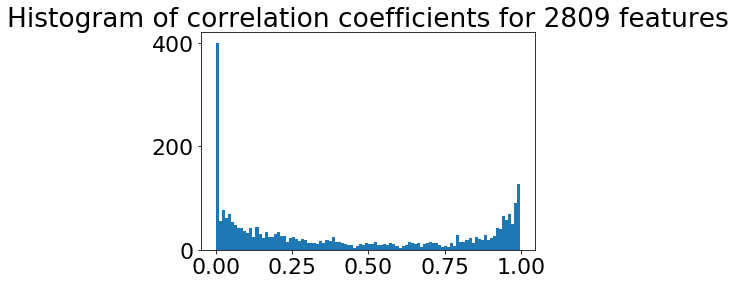

In [37]:
plt.hist(corr, bins=100)
plt.title('Histogram of correlation coefficients for 2809 features')
plt.show()

In [38]:
corr_filter = corr > 0.5

In [39]:
variance = np.var(data.iloc[:, 0:INPUT_DIM])

In [40]:
var_filter = variance != 0

In [41]:
feature_filter = corr_filter & var_filter

In [42]:
X_train_filtered = X_train_norm[:, feature_filter]
X_train_filtered.shape

(15757, 1125)

In [43]:
X_train_filtered_wo_valid = X_train.iloc[:round(0.75*len(X_train)), :]
X_train_filtered_wo_valid = np.array(X_train_filtered_wo_valid)[:, feature_filter]

In [44]:
input_dim = X_train_filtered.shape[1]
input_layer = Input(shape=(input_dim, ))

x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(input_layer)
x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(64, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(32, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(64, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(input_dim)(x)

autoencoder = Model(inputs=input_layer, outputs=x)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1125)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1153024   
_________________________________________________________________
p_re_lu_12 (PReLU)           (None, 1024)              1024      
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
p_re_lu_13 (PReLU)           (None, 512)               512       
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
p_re_lu_14 (PReLU)           (None, 256)               256       
__________

In [45]:
model_name2 = 'ae2'

In [46]:
adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name2)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

In [47]:
autoencoder.fit(X_train_filtered,
                X_train_filtered,
                epochs=2048,
                batch_size=256,
                validation_split=0.25,
                verbose=2,
                callbacks=[early_stopper, checkpoint_callback])

Train on 11817 samples, validate on 3940 samples
Epoch 1/2048
3s - loss: 41.8937 - val_loss: 37.8094
Epoch 2/2048
2s - loss: 34.2858 - val_loss: 31.0164
Epoch 3/2048
1s - loss: 28.1546 - val_loss: 25.4926
Epoch 4/2048
1s - loss: 23.1154 - val_loss: 20.9429
Epoch 5/2048
1s - loss: 18.9761 - val_loss: 17.2092
Epoch 6/2048
2s - loss: 15.5895 - val_loss: 14.1550
Epoch 7/2048
4s - loss: 12.8203 - val_loss: 11.6600
Epoch 8/2048
2s - loss: 10.5568 - val_loss: 9.6220
Epoch 9/2048
1s - loss: 8.7090 - val_loss: 7.9594
Epoch 10/2048
1s - loss: 7.2029 - val_loss: 6.6049
Epoch 11/2048
2s - loss: 5.9772 - val_loss: 5.5028
Epoch 12/2048
1s - loss: 4.9807 - val_loss: 4.6073
Epoch 13/2048
2s - loss: 4.1713 - val_loss: 3.8793
Epoch 14/2048
2s - loss: 3.5139 - val_loss: 3.2878
Epoch 15/2048
2s - loss: 2.9797 - val_loss: 2.8066
Epoch 16/2048
2s - loss: 2.5452 - val_loss: 2.4148
Epoch 17/2048
3s - loss: 2.1915 - val_loss: 2.0956
Epoch 18/2048
2s - loss: 1.9031 - val_loss: 1.8347
Epoch 19/2048
2s - loss: 1.

In [48]:
# Reload saved model
autoencoder = load_model("%s%s.h5" % (model_directory, model_name2))

In [49]:
X_test_filtered = X_test_norm[:, feature_filter]

In [50]:
# Exclude validation set
X_train_wo_valid_filtered = X_train_wo_valid[:, feature_filter]

In [51]:
X_test_filtered.shape

(18698, 1125)

In [52]:
# Run predictions
ae_pred_filtered = autoencoder.predict(X_test_filtered)
ae_pred_filtered_train = autoencoder.predict(X_train_wo_valid_filtered)

In [53]:
pickle.dump(ae_pred_filtered, open(model_directory + "ae_pred_filtered.p", "wb"))
pickle.dump(ae_pred_filtered_train, open(model_directory + "ae_pred_filtered_train.p", "wb"))

In [54]:
ae_pred_filtered = pickle.load(open(model_directory + "ae_pred_filtered.p", "rb"))
ae_pred_filtered_train = pickle.load(open(model_directory + "ae_pred_filtered_train.p", "rb"))

In [55]:
ae_error_filtered = get_error_df(X_test_filtered, ae_pred_filtered, mode="topn", n_highest=100)
ae_error_filtered_train = get_error_df(X_train_wo_valid_filtered, ae_pred_filtered_train, mode="topn", n_highest=100)

In [56]:
pickle.dump(ae_error_filtered, open(model_directory + "ae_error_filtered.p", "wb"))
pickle.dump(ae_error_filtered_train, open(model_directory + "ae_error_filtered_train.p", "wb"))

In [ ]:
plt.rcParams['figure.figsize'] = [30, 30]
plt_dir = '/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/visualization/plots_train_reduced_features/'
bins = np.linspace(-50, 50, 50)
overlap = []
for i in tnrange(X_test_filtered.shape[1]):
    v, r = divmod(i, 7)
    
    # Train set
    good_input_train = X_train_wo_valid_filtered[:, i].reshape(-1)
    good_output_train = ae_pred_filtered_train[:, i].reshape(-1)
    filter_fraction = 1 # in %
    filtered_idx = (good_input_train < np.percentile(good_input_train, 100-filter_fraction))
    filtered_idx &= (good_input_train > np.percentile(good_input_train, filter_fraction))
    filtered_idx &= (good_output_train < np.percentile(good_output_train, 100-filter_fraction))
    filtered_idx &= (good_output_train > np.percentile(good_output_train, filter_fraction))
    good_input_filtered_train = good_input_train[filtered_idx]
    good_output_filtered_train = good_output_train[filtered_idx]
    
    good_input_orig = X_train_filtered_wo_valid[:, i].reshape(-1)
    filtered_orig_idx = (good_input_orig < np.percentile(good_input_orig, 100-filter_fraction))
    filtered_orig_idx &= (good_input_orig > np.percentile(good_input_orig, filter_fraction))
    good_input_orig_filtered_train = good_input_orig[filtered_orig_idx]
    
    # Test set
    good_input_test = X_test_filtered[y_test == 0][:, i].reshape(-1)
    good_output_test = ae_pred_filtered[y_test == 0][:, i].reshape(-1)
    filter_fraction = 1
    filtered_idx = (good_input_test < np.percentile(good_input_test, 100-filter_fraction))
    filtered_idx &= (good_input_test > np.percentile(good_input_test, filter_fraction))
    filtered_idx &= (good_output_test < np.percentile(good_output_test, 100-filter_fraction))
    filtered_idx &= (good_output_test > np.percentile(good_output_test, filter_fraction))
    good_input_filtered_test = good_input_test[filtered_idx]
    good_output_filtered_test = good_output_test[filtered_idx]
    
    bad_input_test = X_test_filtered[y_test == 1][:, i].reshape(-1)
    bad_output_test = ae_pred_filtered[y_test == 1][:, i].reshape(-1)
    filter_fraction = 1
    filtered_idx = (bad_input_test < np.percentile(bad_input_test, 100-filter_fraction))
    filtered_idx &= (bad_input_test > np.percentile(bad_input_test, filter_fraction))
    filtered_idx &= (bad_output_test < np.percentile(bad_output_test, 100-filter_fraction))
    filtered_idx &= (bad_output_test > np.percentile(bad_output_test, filter_fraction))
    bad_input_filtered_test = bad_input_test[filtered_idx]
    bad_output_filtered_test = bad_output_test[filtered_idx]
    
    good_input_orig = X_test_filtered[:, i][y_test == 0].reshape(-1)
    filtered_orig_idx = (good_input_orig < np.percentile(good_input_orig, 100-filter_fraction))
    filtered_orig_idx &= (good_input_orig > np.percentile(good_input_orig, filter_fraction))
    good_input_orig_filtered_test = good_input_orig[filtered_orig_idx]
    
    bad_input_orig = X_test_filtered[:, i][y_test == 1].reshape(-1)
    filtered_orig_idx = (bad_input_orig < np.percentile(bad_input_orig, 100-filter_fraction))
    filtered_orig_idx &= (bad_input_orig > np.percentile(bad_input_orig, filter_fraction))
    bad_input_orig_filtered_test = bad_input_orig[filtered_orig_idx]
    
#     print(len(good_input_filtered))
#     print(len(good_input))
#     cut = 100 * (1 - len(good_input_filtered) / len(good_input))
#     print(cut)
#     overlap_frac = 100 * (4-cut)/2
#     print(overlap_frac)
#     overlap.append(overlap_frac)
    
    fig, axes = plt.subplots(3, 3)
    
    axes[(0, 0)].hist(good_input_orig_filtered_train, 100, histtype='step', linewidth=2, label="Raw input")
    axes[(0, 0)].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' GOOD TRAIN raw input')
    axes[(0, 0)].set_xlabel('Values')
    axes[(0, 0)].set_ylabel('Number of lumisections')
    axes[(0, 0)].legend()
    
    axes[(0, 1)].hist(good_input_orig_filtered_test, 100, histtype='step', linewidth=2, label="Raw input")
    axes[(0, 1)].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' GOOD TEST raw input')
    axes[(0, 1)].set_xlabel('Values')
    axes[(0, 1)].set_ylabel('Number of lumisections')
    axes[(0, 1)].legend()
    
    axes[(0, 2)].hist(bad_input_orig_filtered_test, 100, histtype='step', linewidth=2, label="Raw input")
    axes[(0, 2)].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' BAD raw input')
    axes[(0, 2)].set_xlabel('Values')
    axes[(0, 2)].set_ylabel('Number of lumisections')
    axes[(0, 2)].legend()
    
    axes[(1, 0)].hist(good_input_filtered_train, alpha=0.5, histtype='step', linewidth=2, color='b', 
          label="Normalized input")
    axes[(1, 0)].hist(good_output_filtered_train, alpha=0.5, histtype='step', linewidth=2, color='r', 
          label="AE output")
    axes[(1, 0)].set_xlabel('Values')
    axes[(1, 0)].set_ylabel('Number of lumisections')
    axes[(1, 0)].legend()
    axes[(1, 0)].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' I/O histogram')
    
    axes[1][1].hist(good_input_filtered_test, alpha=0.5, histtype='step', linewidth=2, color='b', 
          label="Normalized input")
    axes[1][1].hist(good_output_filtered_test, alpha=0.5, histtype='step', linewidth=2, color='r', 
          label="AE output")
    axes[1][1].set_xlabel('Values')
    axes[1][1].set_ylabel('Number of lumisections')
    axes[1][1].legend()
    axes[1][1].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' I/O histogram')
    
    axes[1][2].hist(bad_input_filtered_test, alpha=0.5, histtype='step', linewidth=2, color='b', 
          label="Normalized input")
    axes[1][2].hist(bad_output_filtered_test, alpha=0.5, histtype='step', linewidth=2, color='r', 
          label="AE output")
    axes[1][2].set_xlabel('Values')
    axes[1][2].set_ylabel('Number of lumisections')
    axes[1][2].legend()
    axes[1][2].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' I/O histogram')
    
    axes[2][0].hist2d(good_input_filtered_train, good_output_filtered_train, norm=LogNorm(),
                      bins=200)
    axes[2][0].set_title('corr. coeff.:' 
                         + str(round(pearsonr(good_input_train, good_output_train)[0], 2)))
    axes[2][0].set_xlabel('Input values')
    axes[2][0].set_ylabel('Output values')
    axes[2][0].axis('equal')
    
    axes[2][1].hist2d(good_input_filtered_test, good_output_filtered_test, norm=LogNorm(),
                      bins=200)
    axes[2][1].set_title('corr. coeff.:' 
                         + str(round(pearsonr(good_input_test, good_output_test)[0], 2)))
    axes[2][1].set_xlabel('Input values')
    axes[2][1].set_ylabel('Output values')
    axes[2][1].axis('equal')
    
    axes[2][2].hist2d(bad_input_filtered_test, bad_output_filtered_test, norm=LogNorm(), 
                      bins=200)
    axes[2][2].set_title('corr. coeff.:' 
                         + str(round(pearsonr(bad_input_test, bad_output_test)[0], 2)))
    axes[2][2].set_xlabel('Input values')
    axes[2][2].set_ylabel('Output values')
    axes[2][2].axis('equal')
    
#     plt.savefig(plt_dir + str(i) + '_' + feature_names[v] + '_' + var_legend[r]['name'])
    plt.show()
    plt.close()
    print('####################################################################################')

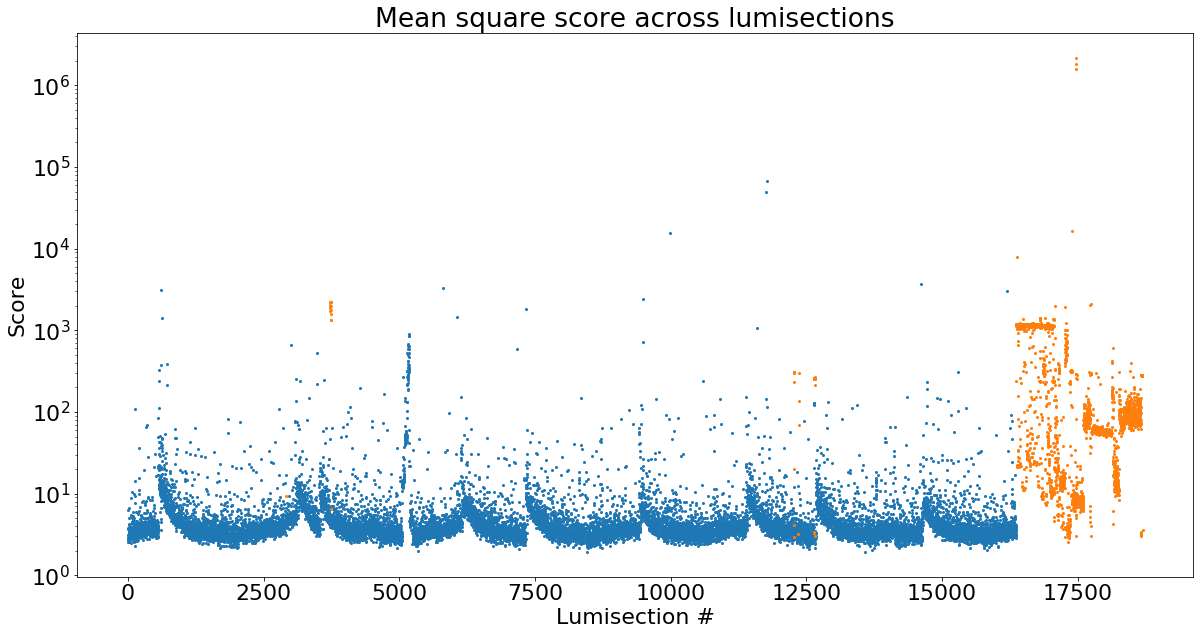

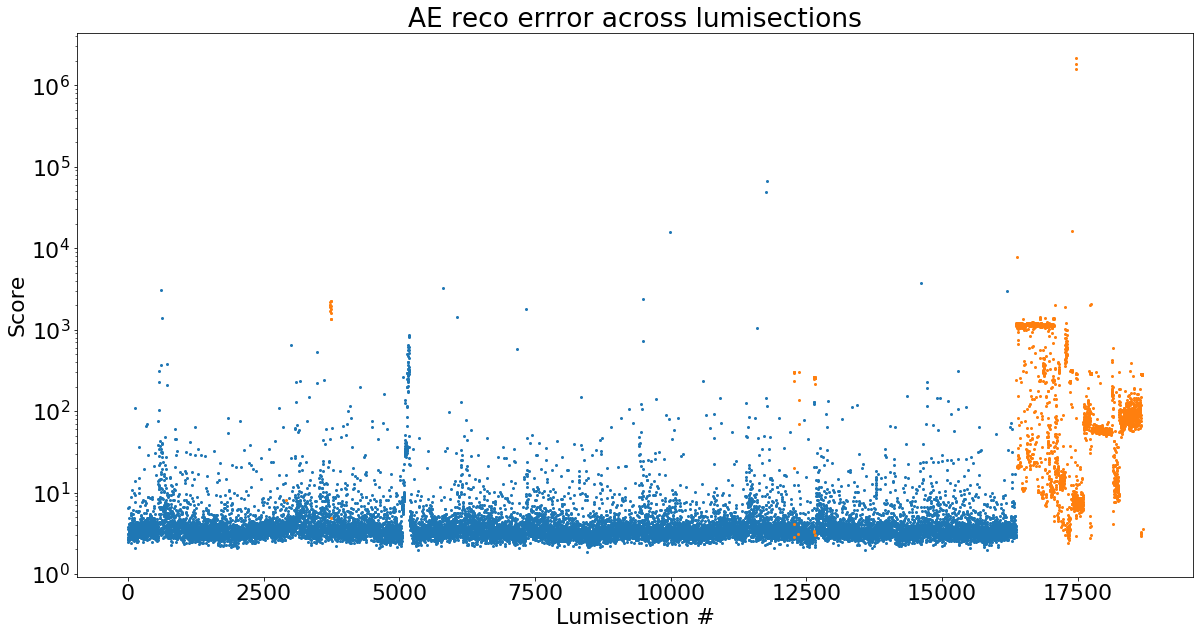

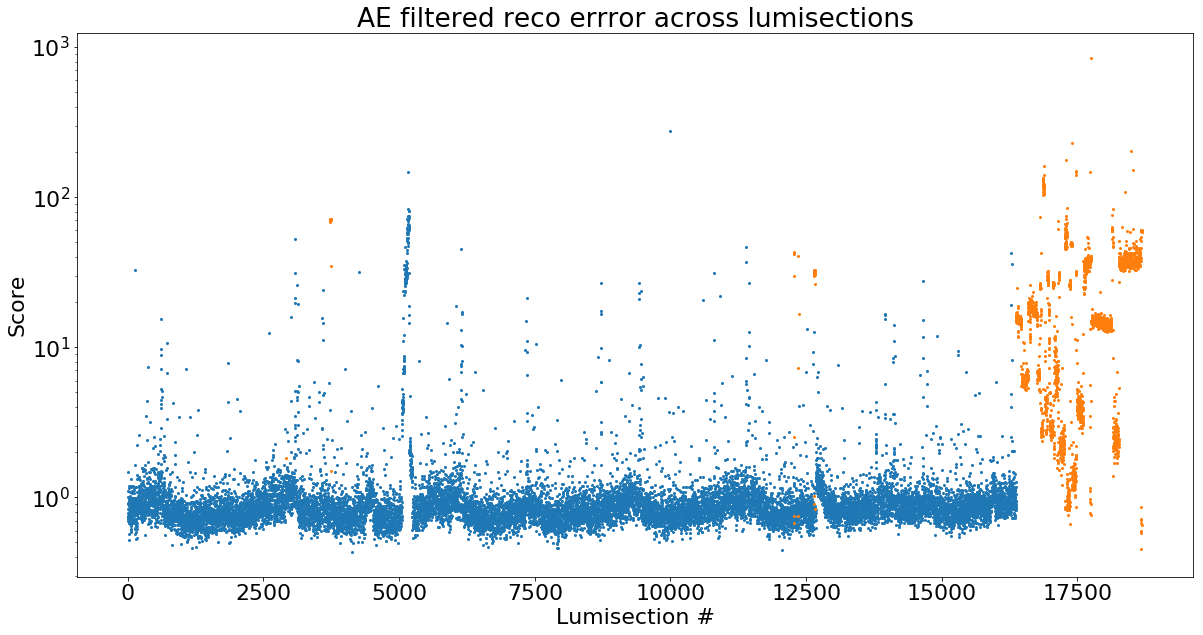

In [57]:
plt.rcParams['figure.figsize'] = [20, 10]
plot_lumi_error(np.zeros(ae_pred.shape), X_test_norm, title='Mean square score across lumisections')
plot_lumi_error(ae_pred, X_test_norm, title='AE reco errror across lumisections')
plot_lumi_error(ae_pred_filtered, X_test_filtered, 
                title='AE filtered reco errror across lumisections')

In [58]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve(label, pred, X_tests, names):
    """Generates ROC Curves for a given array"""
    scores = [get_error_df(X_tests[i], pred[i], mode='topn') for i in range(len(pred))]
    
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show()

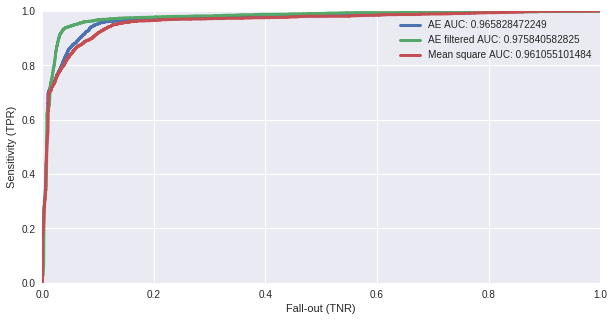

In [65]:
plt.rcParams['figure.figsize'] = [10, 5]
get_roc_curve(y_test, [ae_pred, ae_pred_filtered, np.zeros(ae_pred.shape)],
              [X_test_norm, X_test_filtered, X_test_norm], ['AE', 'AE filtered', 'Mean square'])

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

LABELS = ["Normal", "Anomalous"]

def conf_matrix(scores, y_true, threshold, title):
    y_pred = [1 if e > threshold else 0 for e in scores]
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title(title)
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    class_imbal = np.mean(1 - y_true)
    adj_acc = (acc - class_imbal) / (1 - class_imbal)

    print("Threshold:", threshold)
    print("Adjusted accuracy:", adj_acc)
    return threshold

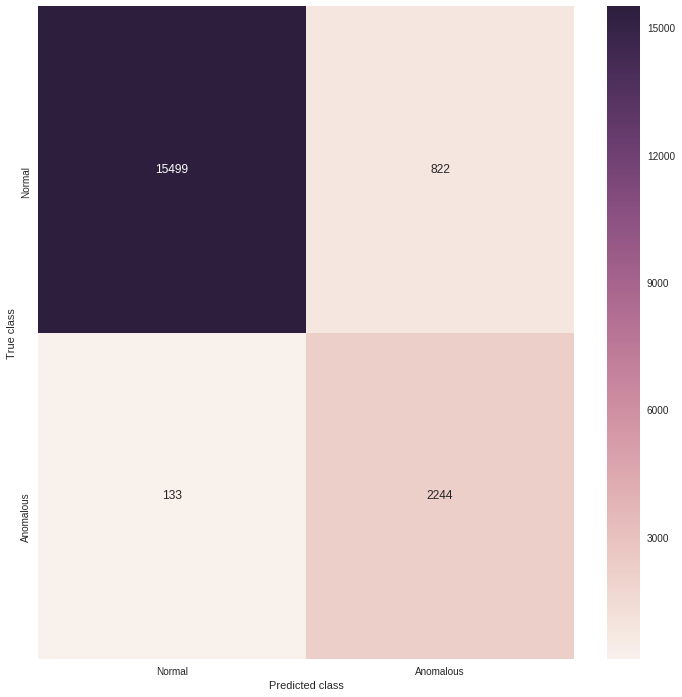

Threshold: 1.5
Adjusted accuracy: 0.598233066891


1.5

In [61]:
conf_matrix(ae_error_filtered, y_test, 1.5e0, '')

In [62]:
def pred_vs_feature(y_val, x_val, y_class, y_name="", x_name="", selected=[], linear=False,
                    limit=False):
    '''
    Plots two arbitrary values agains each other.
    '''
    df = pd.DataFrame({'y_val': y_val,
                       'x_val': x_val,
                       'y_class': y_class})

    groups = df.groupby('y_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.x_val, 
                group.y_val,
                color="red" if name == 1 else "blue",
                marker='o',
                ms=2,
                linestyle='',
                label= "Anomaly" if name == 1 else "Normal")

    for i in selected:
        ax.plot(x_val[i],
                y_val[i],
                color="green",
                marker='o',
                ms=4,
                linestyle='')
                 
    ax.legend()
    if not linear:
        ax.set_yscale('log')
    if limit:
        plt.xlim([limit[0], limit[1]])
    plt.grid()
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.show()

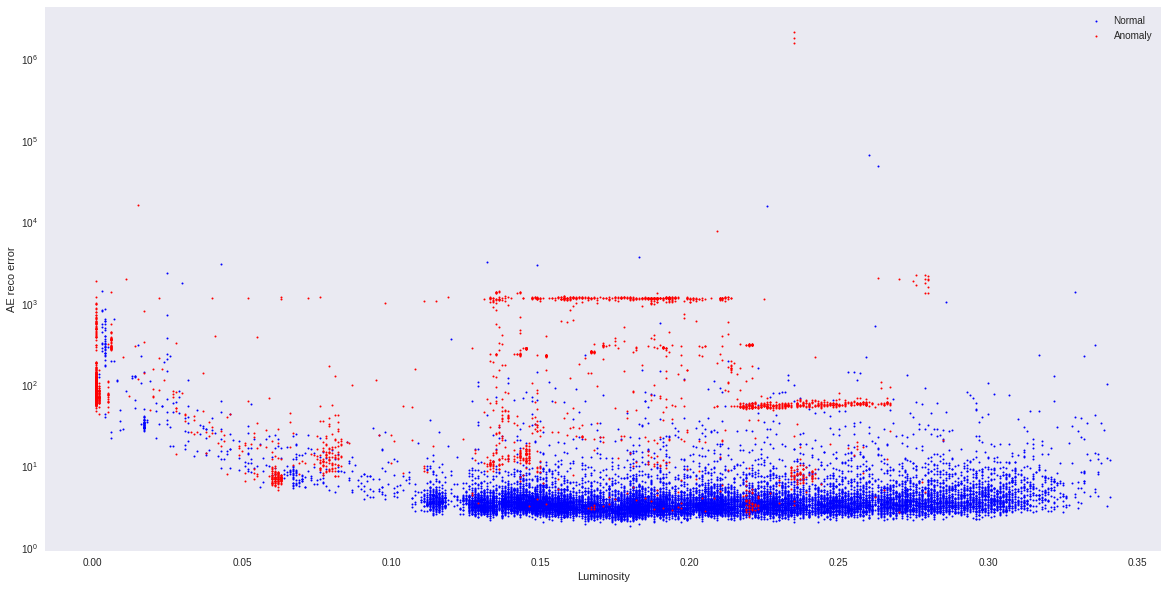

In [63]:
plt.rcParams['figure.figsize'] = [20, 10]
pred_vs_feature(ae_error, X_test[2807], y_test, "AE reco error", "Luminosity")

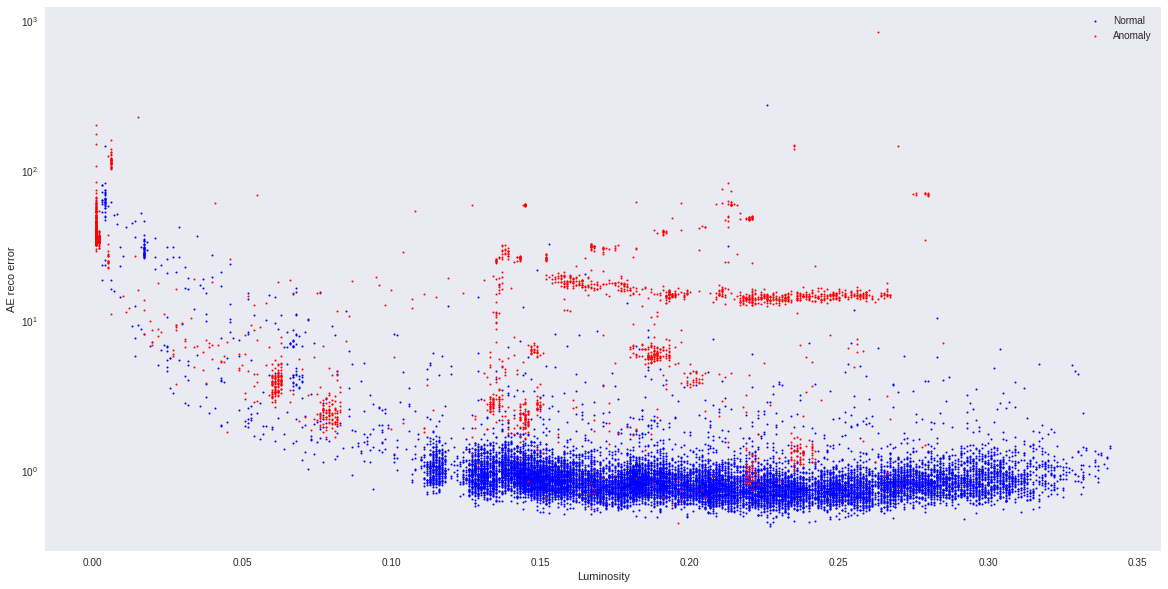

In [64]:
plt.rcParams['figure.figsize'] = [20, 10]
pred_vs_feature(ae_error_filtered, X_test[2807], y_test, "AE reco error", "Luminosity")

In [ ]:
model_directory_np_b = "/eos/user/t/tkrzyzek/autoencoder/plots_train_bottleneck/"
model_directory_p_b = "/eos/user/t/tkrzyzek/autoencoder/plots_train_w_pileup/"
model_directory_p_nb = "/eos/user/t/tkrzyzek/autoencoder/plots_train_w_pileup_no_bottleneck/"
model_directory_np_nb = "/eos/user/t/tkrzyzek/autoencoder/plots_train_no_pileup_no_bottleneck/"

In [ ]:
np_b_ae_error = pickle.load(open(model_directory_np_b + "ae_error.p", "rb"))
np_b_ae_error_filtered = pickle.load(open(model_directory_np_b + "ae_error_filtered.p", "rb"))

p_b_ae_error = pickle.load(open(model_directory_p_b + "ae_error.p", "rb"))
p_b_ae_error_filtered = pickle.load(open(model_directory_p_b + "ae_error_filtered.p", "rb"))


p_nb_ae_error = pickle.load(open(model_directory_p_nb + "ae_error.p", "rb"))
p_nb_ae_error_filtered = pickle.load(open(model_directory_p_nb + "ae_error_filtered.p", "rb"))


np_nb_ae_error = pickle.load(open(model_directory_np_nb + "ae_error.p", "rb"))
np_nb_ae_error_filtered = pickle.load(open(model_directory_np_nb + "ae_error_filtered.p", "rb"))

In [ ]:
def pred_vs_feature4(y_vals, x_val, y_class, y_name="", x_name="", linear=False, 
                     limit=False):
    '''
    Plots two arbitrary values agains each other.
    '''
    fig, axes = plt.subplots(2, 2)
    
    for i in range(4):
        df = pd.DataFrame({'y_val': y_vals[i],
                           'x_val': x_val,
                           'y_class': y_class})

        groups = df.groupby('y_class')
        if i < 2:
            ax = axes[0, i%2]
        else:
            ax = axes[1, i%2]
        
        for name, group in groups:
            ax.plot(group.x_val, 
                    group.y_val,
                    color="red" if name == 1 else "blue",
                    marker='o',
                    ms=2,
                    linestyle='',
                    label= "Anomaly" if name == 1 else "Normal")

        ax.legend()
        if not linear:
            ax.set_yscale('log')
        if limit:
            plt.xlim([limit[0], limit[1]])
        ax.set_ylabel(y_name)
        ax.set_xlabel(x_name)
        plt.grid()
    plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [40, 20]
pred_vs_feature4([np_b_ae_error, p_b_ae_error, p_nb_ae_error, np_nb_ae_error],
                X_test[2807], y_test, "AE reco error", "Luminosity")

In [ ]:
plt.rcParams['figure.figsize'] = [40, 20]
pred_vs_feature4([np_b_ae_error_filtered, p_b_ae_error_filtered, p_nb_ae_error_filtered,
                  np_nb_ae_error_filtered], X_test[2807], y_test, "AE reco error", "Luminosity")

In [ ]:
plt.rcParams['figure.figsize'] = [40, 20]
pred_vs_feature4([np_b_ae_error, p_b_ae_error, p_nb_ae_error, np_nb_ae_error],
                X_test[2808], y_test, "AE reco error", "Pileup")

In [ ]:
plt.rcParams['figure.figsize'] = [40, 20]
pred_vs_feature4([np_b_ae_error_filtered, p_b_ae_error_filtered, p_nb_ae_error_filtered,
                  np_nb_ae_error_filtered], X_test[2808], y_test, "AE reco error", "Pileup")